# Sunspot exploration
Let us start by importing the sunspot number dataset from the [Bruxelles Observatory](https://www.sidc.be/silso/datafiles) rather than from [Kaggle](https://www.kaggle.com/robervalt/sunspots) like most people do. ;)

The dataset we use is labelled "Monthly mean total sunspot number [1/1749 - now]" on the observatory Web site. We download it and store a local copy as "sunspot.csv", unless that file already exists from a previous run.

In [1]:
import pandas as pd
import requests
import os

In [2]:
if not os.path.exists('sunspot.csv'):
    url = 'https://www.sidc.be/silso/INFO/snmtotcsv.php'
    r = requests.get(url, allow_redirects=True)
    open('sunspot.csv', 'wb').write(r.content)

The dataset has no column titles, so we add them ourselves, following the [on-line documentation](https://www.sidc.be/SILSO/infosndtot) which says:

Column 1-2: Gregorian calendar date (Year, Month).  
Column 3: Date in fraction of year.  
Column 4: Monthly mean total sunspot number.  
Column 5: Monthly mean standard deviation of the input sunspot numbers.  
Column 6: Number of observations used to compute the monthly mean total sunspot number.  
Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.

Missing values are indicated by a value of -1

In [3]:
df = pd.read_csv('sunspot.csv', delimiter=";", 
                 names= ["Year", "Month", "Year_Fraction", "SunspotNumber", "SunspotNumber_sd",
                         "NumObservations", "Definitive?"])
df = df[df["Year"]<2024]

Pandas' summary of the dataset:

In [4]:
df.describe()

,Year,Month,Year_Fraction,SunspotNumber,SunspotNumber_sd,NumObservations,Definitive?
count,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.0
mean,1886.000000,6.500000,1886.497992,81.773788,5.637939,117.089697,1.0
std,79.397168,3.452576,79.397664,67.666430,5.289855,249.490775,0.0
min,1749.000000,1.000000,1749.042000,0.000000,-1.000000,-1.000000,1.0
25%,1817.000000,3.750000,1817.769250,24.100000,-1.000000,-1.000000,1.0
50%,1886.000000,6.500000,1886.496500,67.550000,5.400000,30.000000,1.0
75%,1955.000000,9.250000,1955.225000,122.400000,9.425000,31.000000,1.0
max,2023.000000,12.000000,2023.958000,398.200000,29.400000,1587.000000,1.0


The first and last records:

In [5]:
df.head()

,Year,Month,Year_Fraction,SunspotNumber,SunspotNumber_sd,NumObservations,Definitive?
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [6]:
df.tail()

,Year,Month,Year_Fraction,SunspotNumber,SunspotNumber_sd,NumObservations,Definitive?
3295,2023,8,2023.623,114.8,15.0,1247,1
3296,2023,9,2023.705,134.2,18.3,1261,1
3297,2023,10,2023.790,99.9,16.2,1104,1
3298,2023,11,2023.873,107.1,16.9,928,1
3299,2023,12,2023.958,113.5,17.7,785,1


Let us plot this time series.

<Axes: xlabel='Year_Fraction'>

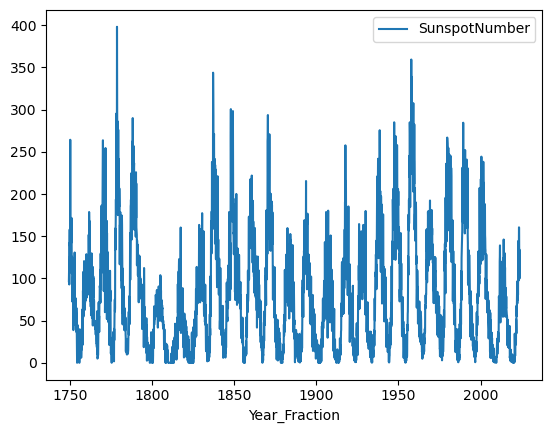

In [7]:
df.plot(x='Year_Fraction', y='SunspotNumber')

Modeling this time series is an interesting exercise in itself. There is obviously a frequential aspect (a 11-years cycle, a 22-years cycle with some variation). Here is an example of a [time series decomposition in R](https://rpubs.com/danielkurnia/timeseries_sunspots).

All we attempt here is a rough estimation of the length of a cycle, without any pretension to scientific rigour.

From the plot, we see that all minima have a count below 20. We thus isolate the points near the minima:

In [8]:
minima = df[df["SunspotNumber"] < 20].copy()
minima

,Year,Month,Year_Fraction,SunspotNumber,SunspotNumber_sd,NumObservations,Definitive?
59,1753,12,1753.958,11.2,-1.0,-1,1
60,1754,1,1754.042,0.0,-1.0,-1,1
61,1754,2,1754.123,5.0,-1.0,-1,1
62,1754,3,1754.204,2.8,-1.0,-1,1
68,1754,9,1754.707,13.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3260,2020,9,2020.706,0.6,2.2,1244,1
3261,2020,10,2020.791,14.6,7.4,1215,1
3264,2021,1,2021.042,10.4,5.9,1036,1
3265,2021,2,2021.122,8.2,4.3,1122,1


A quick plot shows that this selection is reasonable, because it still shows cycles with the same frequency:

<Axes: xlabel='Year_Fraction'>

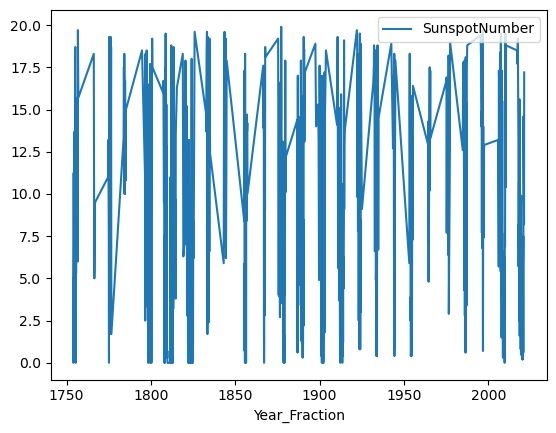

In [9]:
minima.plot(x='Year_Fraction', y='SunspotNumber')

Next, we assign a number to each minimum. We consider that a series of points starts a new minimum if it is more than five years later than the previous point - the number of five being a visual estimate from the plot.

In [10]:
minima["number"] = minima["Year_Fraction"].diff().gt(5).cumsum()
minima

,Year,Month,Year_Fraction,SunspotNumber,SunspotNumber_sd,NumObservations,Definitive?,number
59,1753,12,1753.958,11.2,-1.0,-1,1,0
60,1754,1,1754.042,0.0,-1.0,-1,1,0
61,1754,2,1754.123,5.0,-1.0,-1,1,0
62,1754,3,1754.204,2.8,-1.0,-1,1,0
68,1754,9,1754.707,13.7,-1.0,-1,1,0
...,...,...,...,...,...,...,...,...
3260,2020,9,2020.706,0.6,2.2,1244,1,23
3261,2020,10,2020.791,14.6,7.4,1215,1,23
3264,2021,1,2021.042,10.4,5.9,1036,1,23
3265,2021,2,2021.122,8.2,4.3,1122,1,23


We thus find 24 minima. Let's compute the mean Year_Fraction for each of them:

In [11]:
grouped = minima.groupby("number")
grouped_mean = grouped.mean()
grouped_mean["Year_Fraction"]

number
0     1755.452727
1     1766.549750
2     1775.576063
3     1784.516357
4     1798.471791
5     1815.698811
6     1833.861000
7     1843.860077
8     1856.213783
9     1867.235857
10    1878.022026
11    1889.126976
12    1901.129250
13    1912.692191
14    1923.306320
15    1933.511900
16    1944.014308
17    1954.253476
18    1964.859083
19    1976.072667
20    1986.289750
21    1996.427600
22    2008.511857
23    2019.190933
Name: Year_Fraction, dtype: float64

The differences between successive points give the period of the sunspot number:

In [12]:
grouped_mean["Year_Fraction"].diff()

number
0           NaN
1     11.097023
2      9.026312
3      8.940295
4     13.955434
5     17.227021
6     18.162189
7      9.999077
8     12.353706
9     11.022075
10    10.786169
11    11.104950
12    12.002274
13    11.562941
14    10.614129
15    10.205580
16    10.502408
17    10.239168
18    10.605607
19    11.213583
20    10.217083
21    10.137850
22    12.084257
23    10.679076
Name: Year_Fraction, dtype: float64

There are large variations, especially among the early data which is probably the least reliable. Let's take the average over the last ten periods:

In [13]:
grouped_mean.tail(10)['Year_Fraction'].diff().mean()

10.653845925925932

In [14]:
df.iloc[df["SunspotNumber"].argmax()]

Year                1778.000
Month                  5.000
Year_Fraction       1778.371
SunspotNumber        398.200
SunspotNumber_sd      -1.000
NumObservations       -1.000
Definitive?            1.000
Name: 352, dtype: float64

Get the year/month in which we observe the highest number of sunspots

In [15]:
df[df["SunspotNumber"]==df["SunspotNumber"].max()]

,Year,Month,Year_Fraction,SunspotNumber,SunspotNumber_sd,NumObservations,Definitive?
352,1778,5,1778.371,398.2,-1.0,-1,1
